In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm;

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

In [3]:
# reading the csv file
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

This is a dataset contains a lot of health information which should help predicting strokes. Information like gender, age, bmi index, heart disease, smoking status and so on. I downloaded it on kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

## Introduction - Assessment

This part is all about how the data looks, finding mistakes or things I'd like to change. I chose this data because I want to find a pattern that predicts when people tend to have a stroke.

In [4]:
# taking a peek how the data looks
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.shape

(5110, 12)

In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


I have to find out, which person has 0.08 years. A BMI of 97 is brutally unhealthy but I think there could be someone with that index - the heaviest person on this planet has over 600 kgs. Glucose level is alright as well. 

In [7]:
# Which person has an invalid age number
df[df['age'] == 0.08]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


Might be only with children rows.

In [8]:
df[df['age'] < 2]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
363,7559,Female,0.64,0,0,No,children,Urban,83.82,24.9,Unknown,0
376,22706,Female,0.88,0,0,No,children,Rural,88.11,15.5,Unknown,0
562,45238,Female,1.80,0,0,No,children,Urban,58.26,16.5,Unknown,0
564,61511,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4934,32147,Male,1.32,0,0,No,children,Rural,107.02,NaN,Unknown,0
5032,67426,Female,1.24,0,0,No,children,Rural,61.94,20.3,Unknown,0
5079,42709,Male,1.72,0,0,No,children,Urban,77.28,17.1,Unknown,0
5089,56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0


In [9]:
df[(df['age'] < 40) & (df['age'] > 18)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
49,36338,Female,39.0,1,0,Yes,Private,Rural,58.09,39.2,smokes,1
118,31720,Female,38.0,0,0,No,Self-employed,Urban,82.28,24.0,formerly smoked,1
133,31563,Female,38.0,0,0,Yes,Private,Rural,101.45,NaN,formerly smoked,1
182,39912,Female,32.0,0,0,Yes,Private,Rural,76.13,29.9,smokes,1
210,33943,Female,39.0,0,0,Yes,Private,Urban,83.24,26.3,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5076,39935,Female,34.0,0,0,Yes,Private,Rural,174.37,23.0,never smoked,0
5080,22691,Female,29.0,0,0,Yes,Self-employed,Urban,90.52,28.0,never smoked,0
5083,72914,Female,19.0,0,0,No,Private,Urban,90.57,24.2,Unknown,0
5090,4211,Male,26.0,0,0,No,Govt_job,Rural,100.85,21.0,smokes,0


This doesn't prove anything but let's continue with the assumption, that comma values are only found in ages of kids. 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Therea are NaN values in the BMI and also the smoking status column. In the smoking status columns the NaN values are called "Unknown" which makes them invisible in df.info(). It is important to find out more about that, because the BMI is a very important variable. I think, we might have to get rid of these rows with a NaN value. Luckily it's only 201 people. We'd still have plenty of other people to find patterns from.

In [11]:
df[df['bmi'].isnull()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [12]:
df.loc[df.stroke == 1].shape[0]

249

In [13]:
df.loc[(df.bmi.isna() == True) & (df.stroke == 1)].shape[0]

40

40 strokes out of 249 where BMI is missing. I can't delete that, because I will lose a ton of information about people who had a stroke.

In [14]:
df.duplicated().sum()

0

In [15]:
df[df['smoking_status'] == "Unknown"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
23,64778,Male,82.0,0,1,Yes,Private,Rural,208.30,32.5,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5098,579,Male,9.0,0,0,No,children,Urban,71.88,17.5,Unknown,0
5101,36901,Female,45.0,0,0,Yes,Private,Urban,97.95,24.5,Unknown,0
5103,22127,Female,18.0,0,0,No,Private,Urban,82.85,46.9,Unknown,0
5104,14180,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0


There are 1544 NaN's. That's way too much too be deleted or ignored. 

In [16]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [17]:
df.gender.unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [18]:
df.work_type.unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [19]:
df.smoking_status.unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

## Cleaning

These points have to be done before continuing with this dataset:

- Fill BMI NaN rows with mean.
- ID has to be converted into a string.
- Convert gender, ever married, work type, residence type and smoking status into a categorical column which makes it easier for the visualization part.

In [20]:
# convert id from int to string
df['id'] = df['id'].astype(str)

In [21]:
# checking if it worked. When this prints '0', it worked.
df.id.dtype

dtype('O')

In [22]:
# convert the 7 columns into categorical columns
df['gender'] = df['gender'].astype(CategoricalDtype(categories=['Male','Female', 'Other']))
df['ever_married'] = df['ever_married'].astype(CategoricalDtype(categories=['Yes','No']))
df['work_type'] = df['work_type'].astype(CategoricalDtype(categories=['Private','Self-employed', 'Govt_job', 'children', 'Never_worked']))
df['Residence_type'] = df['Residence_type'].astype(CategoricalDtype(categories=['Urban','Rural']))
df['smoking_status'] = df['smoking_status'].astype(CategoricalDtype(categories=['formerly smoked','never smoked', 'smokes', 'Unknown']))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   object  
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   int64   
 4   heart_disease      5110 non-null   int64   
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   int64   
dtypes: category(5), float64(3), int64(3), object(1)
memory usage: 305.3+ KB


The BMI is totally different for male than for female. That's why we have to get the mean for each gender to have somewhat of a believable fill for these NaN values. After getting each gender's bmi mean, a Concatenation is need to be done.

In [24]:
male_df = df[df['gender'] == 'Male']
female_df = df[df['gender'] == 'Female']

male_df['bmi'].fillna(male_df['bmi'].mean(), inplace=True)
female_df['bmi'].fillna(female_df['bmi'].mean(), inplace=True)

df = pd.concat([male_df, female_df])

C:\Users\Petar\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5109 non-null   object  
 1   gender             5109 non-null   category
 2   age                5109 non-null   float64 
 3   hypertension       5109 non-null   int64   
 4   heart_disease      5109 non-null   int64   
 5   ever_married       5109 non-null   category
 6   work_type          5109 non-null   category
 7   Residence_type     5109 non-null   category
 8   avg_glucose_level  5109 non-null   float64 
 9   bmi                5109 non-null   float64 
 10  smoking_status     5109 non-null   category
 11  stroke             5109 non-null   int64   
dtypes: category(5), float64(3), int64(3), object(1)
memory usage: 345.0+ KB


## Analyzing and Visualizing Data

Let's find some patterns and visualize them!

In [148]:
# like we had above all the imports in one cell, here I'll have all important chart codes at the top
sb.set_style('darkgrid')
base_color = sb.color_palette()[0]

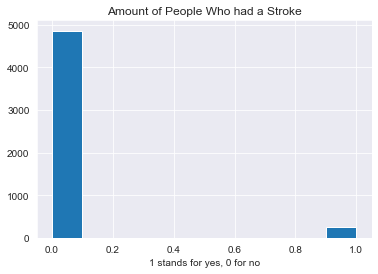

In [27]:
df.stroke.hist()
plt.title('Amount of People Who had a Stroke')
plt.xlabel('1 stands for yes, 0 for no');

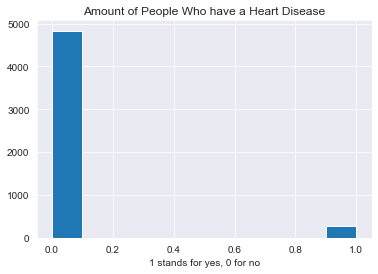

In [28]:
df.heart_disease.hist()
plt.title('Amount of People Who have a Heart Disease')
plt.xlabel('1 stands for yes, 0 for no');

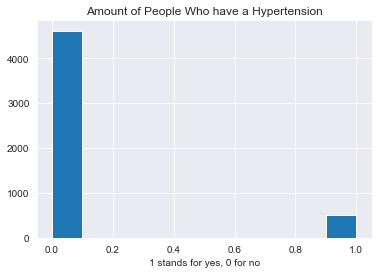

In [29]:
df.hypertension.hist()
plt.title('Amount of People Who have a Hypertension')
plt.xlabel('1 stands for yes, 0 for no');

In [30]:
print(df.heart_disease.value_counts())
print(df.stroke.value_counts())

0    4833
1     276
Name: heart_disease, dtype: int64
0    4860
1     249
Name: stroke, dtype: int64


There we have our first pattern. Someone with a heart disease tend to get a stroke. 

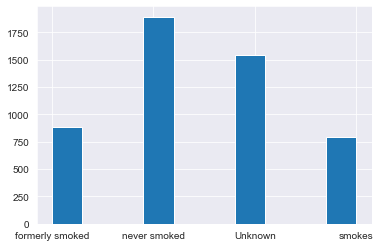

In [31]:
# smoker categorization
df.smoking_status.hist();

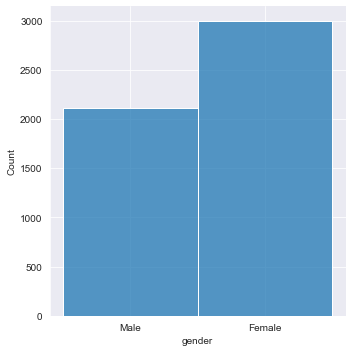

In [32]:
# gender distribution
sb.displot(df.gender);

In [156]:
df.gender.value_counts()

Female    2994
Male      2115
Other        0
Name: gender, dtype: int64

In [34]:
df.drop(df[df['gender'] == "Other"].index, inplace = True)

In [155]:
df[df['gender'] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5109 non-null   object  
 1   gender             5109 non-null   category
 2   age                5109 non-null   float64 
 3   hypertension       5109 non-null   int64   
 4   heart_disease      5109 non-null   int64   
 5   ever_married       5109 non-null   category
 6   work_type          5109 non-null   category
 7   Residence_type     5109 non-null   category
 8   avg_glucose_level  5109 non-null   float64 
 9   bmi                5109 non-null   float64 
 10  smoking_status     5109 non-null   category
 11  stroke             5109 non-null   int64   
dtypes: category(5), float64(3), int64(3), object(1)
memory usage: 474.1+ KB


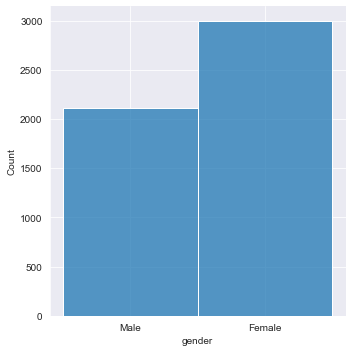

In [37]:
sb.displot(df.gender);

In [38]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276367,0.263777,0.238323,0.325823,0.245239
hypertension,0.276367,1.000000,0.108292,0.174540,0.160125,0.127891
heart_disease,0.263777,0.108292,1.000000,0.161907,0.038615,0.134905
avg_glucose_level,0.238323,0.174540,0.161907,1.000000,0.168785,0.131991
bmi,0.325823,0.160125,0.038615,0.168785,1.000000,0.038840
stroke,0.245239,0.127891,0.134905,0.131991,0.038840,1.000000


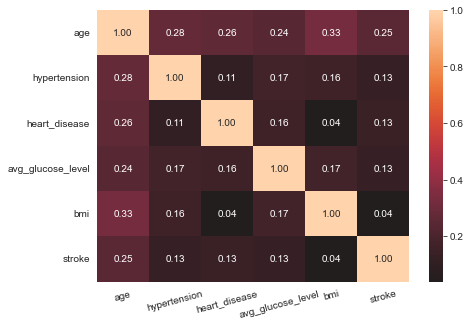

In [39]:
plt.subplots(figsize = (7, 5))
ax = sb.heatmap(df.corr(), annot = True, fmt = '.2f', center = 0)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 15);

The greatest correlation in having a stroke lies in age and the lowest in BMI. 

In [40]:
# whats the average age of people having a stroke
had_strokes = df.query('stroke == 1')
average_age_strokes = had_strokes.age.mean()
average_age_strokes

67.72819277108434

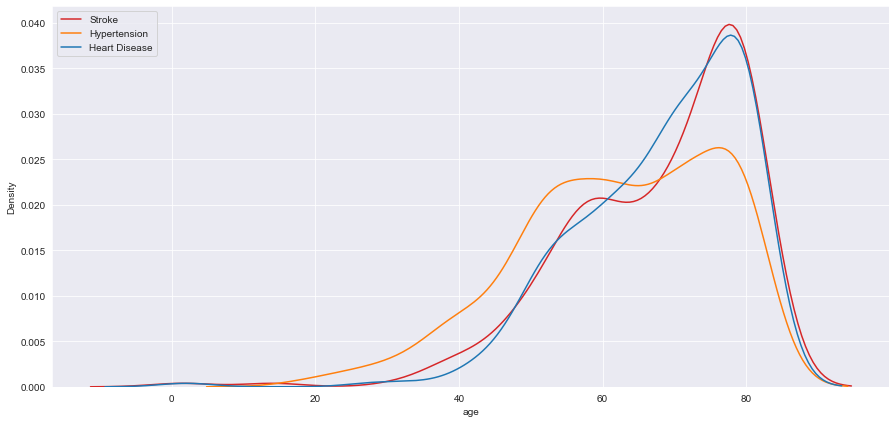

In [41]:
fig, ax = plt.subplots(figsize = (15, 7))

sb.kdeplot(data = df[df['stroke'] == 1]['age'], color = sb.color_palette()[3], label = 'Stroke')
sb.kdeplot(data = df[df['hypertension'] == 1]['age'], color = sb.color_palette()[1], label = 'Hypertension')
sb.kdeplot(data = df[df['heart_disease'] == 1]['age'], color = sb.color_palette()[0], label = 'Heart Disease')

ax.legend(loc = 2);

In [42]:
# chance of getting a stroke generally speaking
stroke_chance = had_strokes.shape[0]/df.shape[0]
print(stroke_chance)

0.04873752201996477


In [43]:
# Probability a person suffering from high blood pressure also suffers a stroke, or P(stroke|hypertension)
df.query('hypertension == 1')['stroke'].mean()

0.13253012048192772

In [44]:
# Probability a person suffering from a heart disease also suffers a stroke, or P(stroke|heart_disease)
df.query('heart_disease == 1')['stroke'].mean()

0.17028985507246377

In [45]:
# Probability a man suffering from a stroke, or P(stroke|male)
df.query('gender == "Male"')['stroke'].mean()

0.05106382978723404

In [46]:
# Probability a woman suffering from a stroke, or P(stroke|female)
df.query('gender == "Female"')['stroke'].mean()

0.047094188376753505

It's quit interesting that we have 1000 less men in this dataset but the chances are still higher to get a stroke for men than for women. Let's bootstrap these probabilities to make statements about the population:

Text(0, 0.5, 'Frequency')

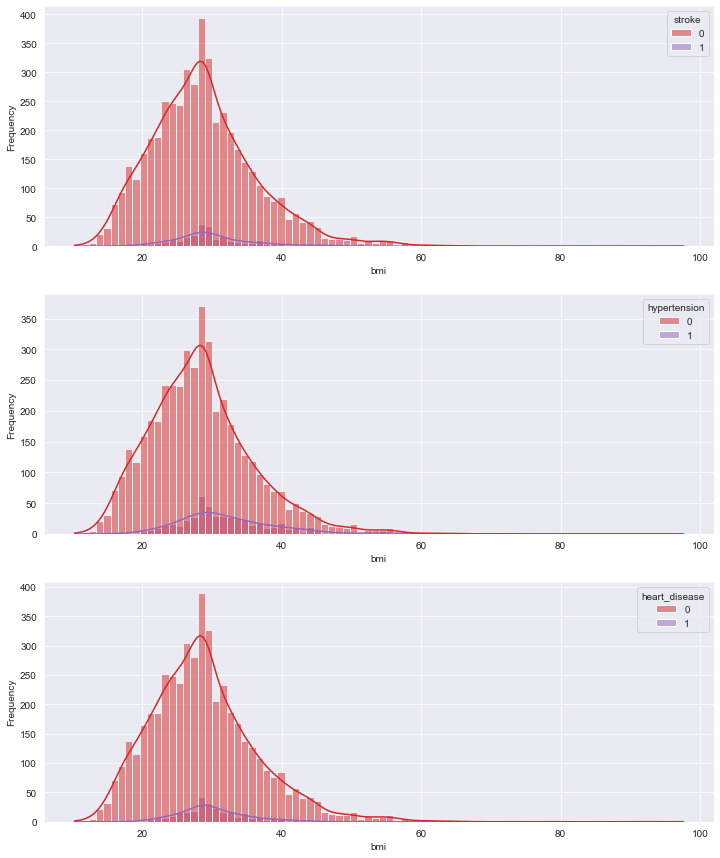

In [47]:
fig, ax = plt.subplots(3,1, figsize=(12,15))

sb.histplot(data= df, x ='bmi', kde=True, hue='stroke', ax=ax[0], palette=[sb.color_palette()[3],sb.color_palette()[4]])
ax[0].set_ylabel("Frequency")

sb.histplot(data= df, x ='bmi', kde=True, hue='hypertension', ax=ax[1], palette=[sb.color_palette()[3],sb.color_palette()[4]])
ax[1].set_ylabel("Frequency")

sb.histplot(data= df, x ='bmi', kde=True, hue='heart_disease', ax=ax[2], palette=[sb.color_palette()[3],sb.color_palette()[4]])
ax[2].set_ylabel("Frequency")

This shows together with the correlation that the BMI isn't the trigger for heart disease, strokes and hypertensions. Now I'll focuse on glucose numbers.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5109 non-null   object  
 1   gender             5109 non-null   category
 2   age                5109 non-null   float64 
 3   hypertension       5109 non-null   int64   
 4   heart_disease      5109 non-null   int64   
 5   ever_married       5109 non-null   category
 6   work_type          5109 non-null   category
 7   Residence_type     5109 non-null   category
 8   avg_glucose_level  5109 non-null   float64 
 9   bmi                5109 non-null   float64 
 10  smoking_status     5109 non-null   category
 11  stroke             5109 non-null   int64   
dtypes: category(5), float64(3), int64(3), object(1)
memory usage: 474.1+ KB


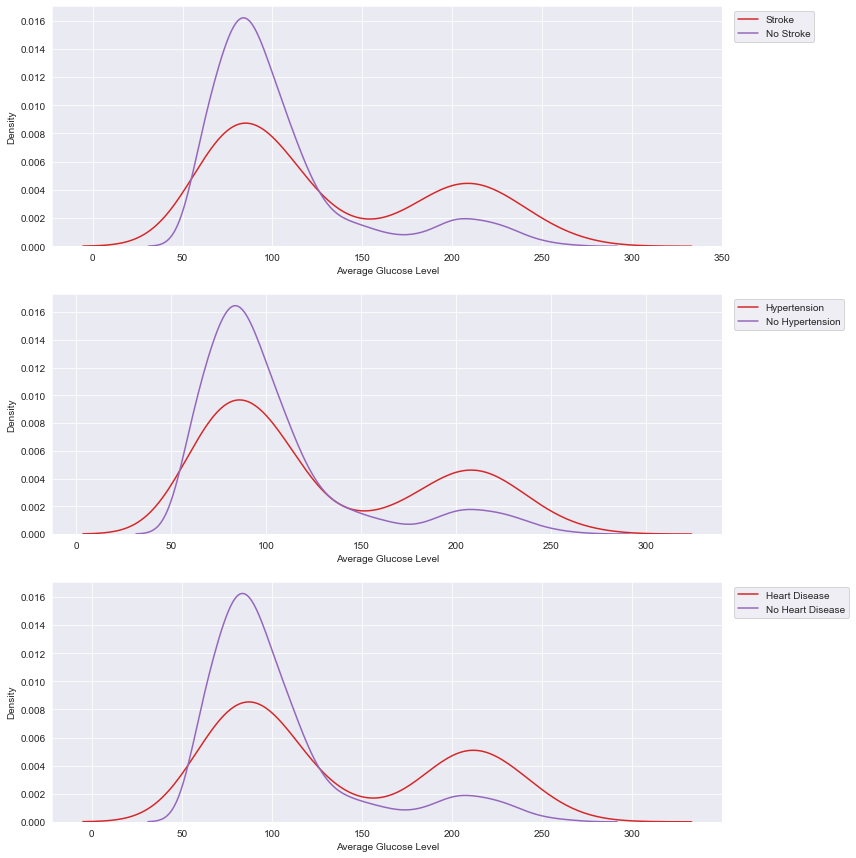

In [49]:
fig, ax = plt.subplots(3,1, figsize=(12,15))


sb.kdeplot(data=df, x=df[df['stroke'] == 1]['avg_glucose_level'], ax=ax[0], color=sb.color_palette()[3], label='Stroke')
sb.kdeplot(data=df, x=df[df['stroke'] == 0]['avg_glucose_level'], ax=ax[0], color=sb.color_palette()[4], label='No Stroke')

ax[0].set_xlabel("Average Glucose Level")
ax[0].legend(bbox_to_anchor = (1.01, 1), loc = 2)


sb.kdeplot(data=df, x=df[df['hypertension'] == 1]['avg_glucose_level'], ax=ax[1], color=sb.color_palette()[3], label='Hypertension')
sb.kdeplot(data=df, x=df[df['hypertension'] == 0]['avg_glucose_level'], ax=ax[1], color=sb.color_palette()[4], label='No Hypertension')

ax[1].set_xlabel("Average Glucose Level")
ax[1].legend(bbox_to_anchor = (1.01, 1), loc = 2)


sb.kdeplot(data=df, x=df[df['heart_disease'] == 1]['avg_glucose_level'], ax=ax[2], color=sb.color_palette()[3], label='Heart Disease')
sb.kdeplot(data=df, x=df[df['heart_disease'] == 0]['avg_glucose_level'], ax=ax[2], color=sb.color_palette()[4], label='No Heart Disease')

ax[2].set_xlabel("Average Glucose Level")
ax[2].legend(bbox_to_anchor = (1.01, 1), loc = 2);

All graphs look more or less the same regardless of whether the condition applies or not. They have the same two extreme points. My Google search reveiled following information: "Normal blood glucose level (while fasting) range within 70 to 99 mg/dL (3.9 to 5.5 mmol/L). Higher ranges could indicate pre-diabetes or diabetes." These chart show that having diabetes doesn't instantly lead to heart disease, hypertension or strokes. There were more health issues in the normal intervall than in the diabetes zone. Above we've seen that there is only one strong correlation - BMI and age. I'll look for a nice plot for these two variables.

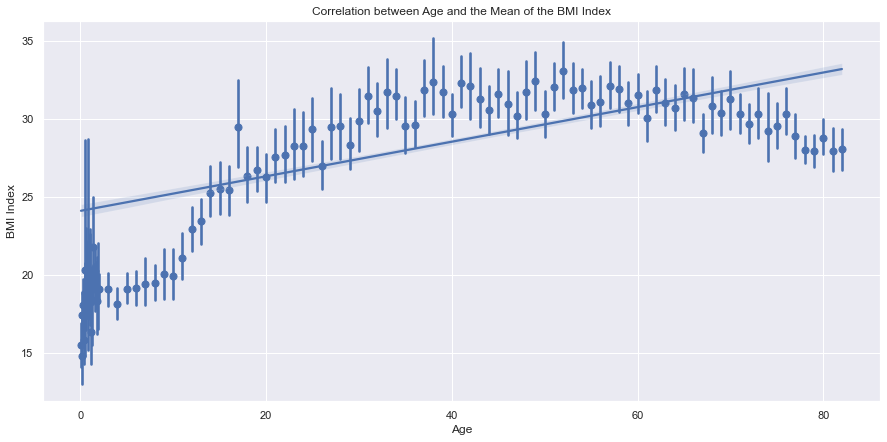

In [153]:
# I'm curious to see the correlation between the age and the bmi index.
fig, ax = plt.subplots(figsize = (15, 7))

ax = sb.regplot(data = df, x = "age", y = "bmi", x_estimator = np.mean)
ax.set_xlabel('Age')
ax.set_ylabel('BMI Index')
plt.title('Correlation between Age and the Mean of the BMI Index');

Well, the older you get, the fatter you become. I can't blame them for enjoying nice food. I would do it like the mean of the people <3.

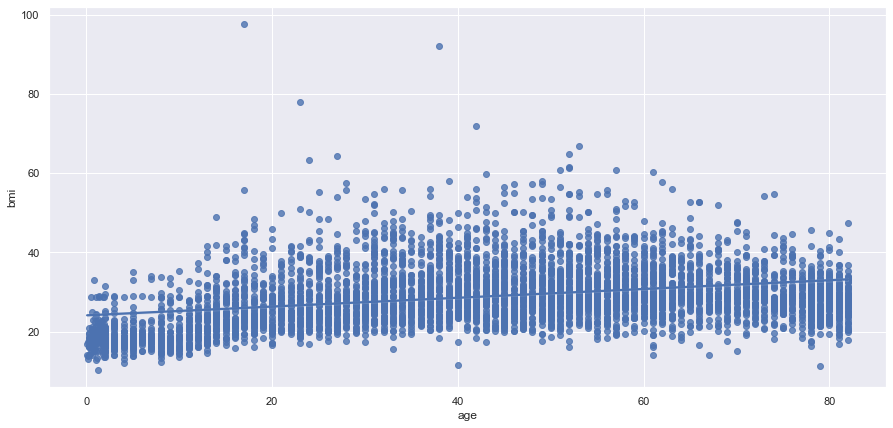

In [150]:
# I'm curious to see the correlation between the age and the bmi index.
fig, ax = plt.subplots(figsize = (15, 7))
ax = sb.regplot(data = df, x = "age", y = "bmi")

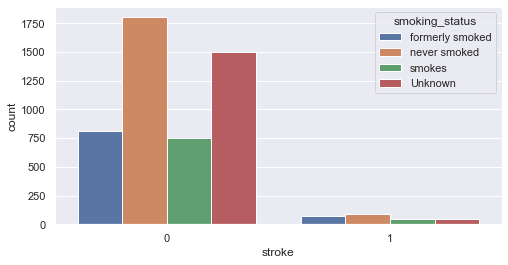

In [161]:
fig, ax = plt.subplots(figsize = (8, 4))

ax = sb.countplot(data = df, x = 'stroke', hue = 'smoking_status');

In [162]:
df.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

As you might realized, this bar chart about the smoking status is pretty unfair towards the non smokers, because there is nearly 2.5 times more data about non smokers than the others.

In [204]:
never_smoked_nmbr = df[df['smoking_status'] == 'never smoked']
unknown_smoked_nmbr = df[df['smoking_status'] == 'Unknown']
formerly_smoked_nmbr = df[df['smoking_status'] == 'formerly smoked']
smokes_nmbr = df[df['smoking_status'] == 'smokes']

In [205]:
# getting the procent numbers out of each category
never_smoked_nmbr = never_smoked_nmbr[never_smoked_nmbr['stroke'] == 1].shape[0]*100/df[df['smoking_status'] == 'never smoked'].shape[0]
unknown_smoked_nmbr = unknown_smoked_nmbr[unknown_smoked_nmbr['stroke'] == 1].shape[0]*100/df[df['smoking_status'] == 'Unknown'].shape[0]
formerly_smoked_nmbr = formerly_smoked_nmbr[formerly_smoked_nmbr['stroke'] == 1].shape[0]*100/df[df['smoking_status'] == 'formerly smoked'].shape[0]
smokes_nmbr = smokes_nmbr[smokes_nmbr['stroke'] == 1].shape[0]*100/df[df['smoking_status'] == 'smokes'].shape[0]

In [206]:
print("Smoker Percentage: {:.1f}%".format(smokes_nmbr))
print("EX-Smoker Percentage: {:.1f}%".format(formerly_smoked_nmbr))
print("Non-Smoker Percentage: {:.1f}%".format(never_smoked_nmbr))
print("Unknown-Smoker Percentage: {:.1f}%".format(unknown_smoked_nmbr))

Smoker Percentage: 5.3%
EX-Smoker Percentage: 7.9%
Non-Smoker Percentage: 4.8%
Unknown-Smoker Percentage: 3.0%


In [231]:
smoking_list = {"Smoker" : smokes_nmbr, "Former Smoker" : formerly_smoked_nmbr,
                "Non Smoker" : never_smoked_nmbr, "Unknown" : unknown_smoked_nmbr}

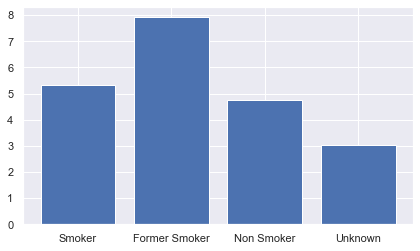

In [235]:
# new plot with the percentages
plt.subplots(figsize=(7, 4))
plt.bar(range(len(smoking_list)), list(smoking_list.values()), align = 'center')
plt.xticks(range(len(smoking_list)), list(smoking_list.keys()));

This looks fairer. There is a limitation to this data chart. I didn't analyze it with the age and other variables and of course there is a huge amount of unknown variables. We can't read out of this chart if former smokers were older people. The same applies for the other categories. 

## Logistic Regression

In [51]:
df_copy = df.copy()

In [52]:
# creating dummy variables for the category variables and dropping the first column since it's reduntand
df_copy = pd.get_dummies(df_copy, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)
df_copy.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Other,ever_married_No,work_type_Self-employed,work_type_Govt_job,work_type_children,work_type_Never_worked,Residence_type_Rural,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown
0,9046,67.0,0,1,228.69,36.600000,1,0,0,0,0,0,0,0,0,0,0,0
2,31112,80.0,0,1,105.92,32.500000,1,0,0,0,0,0,0,0,1,1,0,0
5,56669,81.0,0,0,186.21,29.000000,1,0,0,0,0,0,0,0,0,0,0,0
6,53882,74.0,1,1,70.09,27.400000,1,0,0,0,0,0,0,0,1,1,0,0
13,8213,78.0,0,1,219.84,28.647936,1,0,0,0,0,0,0,0,0,0,0,1


In [126]:
# creating lists for the numeric and category columns
numeric_cols = ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
cat_cols = list(set(df_copy.columns) - set(numeric_cols) - {'stroke'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
['Residence_type_Rural', 'ever_married_No', 'gender_Female', 'gender_Other', 'smoking_status_Unknown', 'smoking_status_never smoked', 'smoking_status_smokes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Self-employed', 'work_type_children']


<p>To make sure the fitted model can be generalized to unseen data, we always train it using some data while evaluating the model using the holdout data. So we need to split the original dataset into training and test datasets. </p>
<br> 
- test_size = 0.2: keep 20% of the original dataset as the test dataset, i.e., 80% as the training dataset.
<br>
- stratify = df['stroke']: when the dataset is imbalanced, it’s good practice to do stratified sampling. In this way, both the training and test datasets will have similar portions of the target classes as the complete dataset.
<br> 
<p> To verify the specifications, we can print out the shapes and the classes of target for both the training and test sets </p>

In [127]:
random_seed = 888
# train for modelling and test for evaluation
df_train, df_test = train_test_split(df_copy, test_size=0.2, random_state=random_seed, stratify = df_copy['stroke'])

print(df_train.shape)
print(df_test.shape)
print()
print(df_train['stroke'].value_counts(normalize=True))
print()
print(df_test['stroke'].value_counts(normalize=True))

(4087, 18)
(1022, 18)

0    0.951309
1    0.048691
Name: stroke, dtype: float64

0    0.951076
1    0.048924
Name: stroke, dtype: float64


Before fitting the model, let’s also scale the numerical variables, which is another common practice in machine learning. 
<br>
After creating a class of StandardScaler, we calculate (fit) the mean and standard deviation for scaling using df_train’s numeric_cols. Then we create a function get_features_and_target_arrays that:

- performs standardization on the numeric_cols of df to return the new array X_numeric_scaled. 
- transforms cat_cols to a NumPy array X_categorical.
- combines both arrays back to the entire feature array X.
- assigns the target column to y.

<p> Then we can apply this function to the training dataset to output our training feature and target, X and y.

This step has to be done after the train test split since the scaling calculations are based on the training dataset. </p>

In [128]:
scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

def get_features_and_target_arrays(df_copy, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df_copy[numeric_cols])
    X_categorical = df_copy[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    y = df_copy['stroke']
    return X, y

X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

In [129]:
# Finally, we can fit the logistic regression in Python on our example dataset.
# We first create an instance clf of the class LogisticRegression. Then we can fit it using the training dataset.
clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
clf.fit(X, y)

LogisticRegression(penalty='none')

At this point, we have the logistic regression model for our example in Python!

After fitting the model, let’s look at some popular evaluation metrics for the dataset.

In [130]:
X_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

C:\Users\Petar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


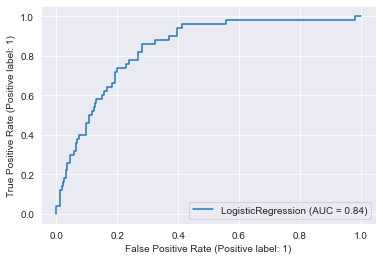

In [131]:
plot_roc_curve(clf, X_test, y_test);

The most “ideal” model has a ROC curve that reaches the top left corner (coordinate (0, 1)) of the plot: an FPR of zero, and a TPR of one. While this is not realistic, we can tell that the larger the two-dimensional Area Under the ROC Curve (AUC or AUROC), the better the model.

The AUC, ranging between 0 and 1, is a model evaluation metric, irrespective of the chosen classification threshold. The AUC of a model is equal to the probability that this classifier ranks a randomly chosen Positive example higher than a randomly chosen Negative example. The model that can predict 100% correct has an AUC of 1.

C:\Users\Petar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


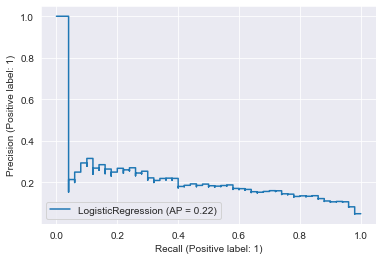

In [132]:
plot_precision_recall_curve(clf, X_test, y_test);

Precision measures the proportion of positive prediction results that are correct.
Recall measures the probability of detection or the proportion of actual positives that were predicted correctly. Even though we want to maximize both metrics, it’s not realistic, so we need to find the tradeoff between them.

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In [133]:
test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

In [134]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.15731
AUC = 0.83774
Average Precision = 0.22057

Using 0.5 as threshold:
Accuracy = 0.95205
Precision = 1.00000
Recall = 0.02000
F1 score = 0.03922

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022



Confusion Matrix


C:\Users\Petar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


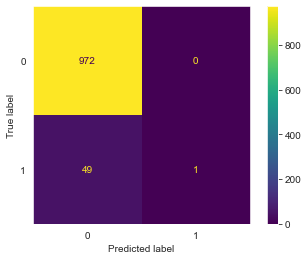

In [135]:
print('Confusion Matrix')
plot_confusion_matrix(clf, X_test, y_test)
plt.grid(None);

In [136]:
coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
pd.DataFrame(data={'Variable': ['intercept'] + cat_cols + numeric_cols, 'Coefficient': coefficients})

,Variable,Coefficient
0,intercept,-3.857238
1,Residence_type_Rural,-0.103133
2,ever_married_No,-0.000348
3,gender_Female,0.082281
4,gender_Other,0.000000
5,smoking_status_Unknown,-0.041651
6,smoking_status_never smoked,-0.232610
7,smoking_status_smokes,-0.009193
8,work_type_Govt_job,-0.190681
9,work_type_Never_worked,-7.942460


<b>Way to interpret this table:</b>
<br>
- For categorical feature gender, this fitted model says that holding all the other features at fixed values, the odds of having heart disease for female (gender_Female = 1) to the odds of having heart disease for males is exp(0.082281) = 1.08576086577. 
<br>
- For categorical feature work_type, we have created dummy variables for it, the reference value is typical 'Private' sector (work_type_Private = 1). So the odds ratio of never_worked (work_type_Never_worked = 1) to Private (work_type_Private = 1) is exp(-7.942460) = 0.00035533128. and so on...

In [137]:
# Since the numerical variables are scaled by StandardScaler, we need to think of them in terms of standard deviations.
# Let’s first print out the list of numeric variable and its sample standard deviation.
pd.DataFrame(data={'variable': numeric_cols, 'unit': np.sqrt(scaler.var_)})

,variable,unit
0,id,21061.557952
1,age,22.595882
2,hypertension,0.297802
3,heart_disease,0.225196
4,avg_glucose_level,45.034726
5,bmi,7.695246


<b>Way to interpret this table:</b> 
<br>
- Age: exp(1.642159) = 5.16631154671 |
Holding other variables fixed, there is a 416.6% increase in the odds of having a stroke for every standard deviation increase in age (22.595882) since exp(1.642159) = 5.16631154671.
<br>
- Average glucose level: exp(0.157364) = 1.17042156982 |
Holding other variables fixed, there is a 17% increase in the odds of having a stroke for every standard deviation increase in average glucose level (45.034726) since exp(0.157364) = 1.17042156982.
<br>
- BMI: exp(-0.054019) = 0.94741410546 |
Holding other variables fixed, there is a 5.3% decrease in the odds of having a stroke for every standard deviation increase in bmi (7.695246) since exp(-0.054019) = 0.94741410546. Well as we saw above, the BMI index doesn't imply getting a stroke. In fact with the data we have, it implies, that having a higher bmi index means having a lower chance of getting a stroke. This is limited to the fact that I had to fill NaN values in the BMI columns with the mean of each gender. It could make sense, because having a higher BMI generally means that you are fatter. Not everyone who is fat eats nothing but sugar, fat and all these super unhealthy things. 

## Resources

https://www.kaggle.com/code/noahdegunst/stroke-analysis
<br>
https://www.justintodata.com/logistic-regression-example-in-python/
<br>
https://www.justintodata.com/machine-learning-model-evaluation-metrics/
<br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
<br>
https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
<br>
https://www.justintodata.com/imbalanced-data-machine-learning-classification/
<br>
<br>
